In [193]:
import sys
sys.path.insert(0, '/home/zahradnik/PycharmProjects/master_thesis')

In [194]:
from src.modules import conf, fit, df_columns, evl, preprocess
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import gpxpy
import haversine as hs
import numpy as np
import statsmodels.api as sm

warnings.simplefilter("ignore")

In [195]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [196]:
%matplotlib inline
plt.rcParams['figure.figsize'] = [24, 8]
plt.rcParams['figure.dpi']

100.0

In [197]:
data = fit.load_pcls(
    athlete_name='zahradnik',
    activity_type='running',
    path_to_load=conf["Paths"]["pcl"],
)

100%|██████████| 386/386 [00:00<00:00, 1292.94it/s]


In [198]:
# ZONES ADD
for x in range(len(data)):
    data[x] = data[x][df_columns]
    mean_hr = np.mean(data[x].heart_rate)
    if mean_hr < 140:
        zone = 1
    elif mean_hr > 140 and mean_hr < 156:
        zone = 2
    elif mean_hr > 156 and mean_hr < 166:
        zone = 3
    elif mean_hr > 166 and mean_hr < 175:
        zone = 4
    elif mean_hr > 175:
        zone = 5
    data[x]['hr_zone'] = zone

In [199]:
low_dist = []
high_dist = []
for act in data:
    if np.max(act.distance) > 10000:
        high_dist.append(act)
    else:
        low_dist.append(act)
len(low_dist),len(high_dist)

(149, 237)

In [200]:
race_index = fit.get_race_index(high_dist, "2022-10-02-10-30") # HRADEC - 1:16 - 1:14
# race_index = fit.get_race_index(low_dist, "2022-11-13-10-59") # VELKA KUNRATICKA 15:20 - 13:20
# race_index = fit.get_race_index(high_dist, "2022-10-08-11-18") # BEROUNKA RUN 90:30 - 95:30
# race_index = fit.get_race_index(high_dist, "2022-12-31-11-00") # SILVESTRAK 18:20 - 17:20
print(race_index)
train_df = fit.clean_data(pd.concat(high_dist[0:race_index]))
test_df = data[fit.get_race_index(data, "2022-10-02-10-30")]
len(train_df),len(test_df)

174


(471641, 4413)

In [201]:
train_df.index[-1],test_df.index[0]

(Timestamp('2022-10-01 10:57:17'), Timestamp('2022-10-02 10:30:09'))

In [202]:
speed_train = train_df.enhanced_speed
speed_test = test_df.enhanced_speed

heart_train = train_df.heart_rate
heart_test=test_df.heart_rate

cad_train = train_df.cadence
cad_test=test_df.cadence

train_df.drop("heart_rate",axis=1,inplace=True)
train_df.drop("enhanced_speed",axis=1,inplace=True)

test_df.drop("heart_rate",axis=1,inplace=True)
test_df.drop("enhanced_speed",axis=1,inplace=True)
#
train_df.drop("cadence",axis=1,inplace=True)
test_df.drop("cadence",axis=1,inplace=True)

In [203]:
from feature_engine.datetime import DatetimeFeatures
train_df['date'] = train_df.index
test_df['date'] = test_df.index
dtf = DatetimeFeatures(features_to_extract=['month','week','hour','minute','second'])
train_df= dtf.fit_transform(train_df)
test_df= dtf.fit_transform(test_df)

In [204]:
from feature_engine.timeseries.forecasting import WindowFeatures
lagged_cols = ['slope_steep','slope_ascent','slope_descent']
lagged = 18
for lag in range(1,lagged):
    wft = WindowFeatures(variables=lagged_cols,
                         window=lag)
    train_df = wft.fit_transform(train_df)
    test_df = wft.fit_transform(test_df)

In [205]:
for colname in train_df.columns:
    if 'mean' in colname:
        train_df[colname].fillna(0,inplace=True)
        test_df[colname].fillna(0,inplace=True)

0.9620898114435972


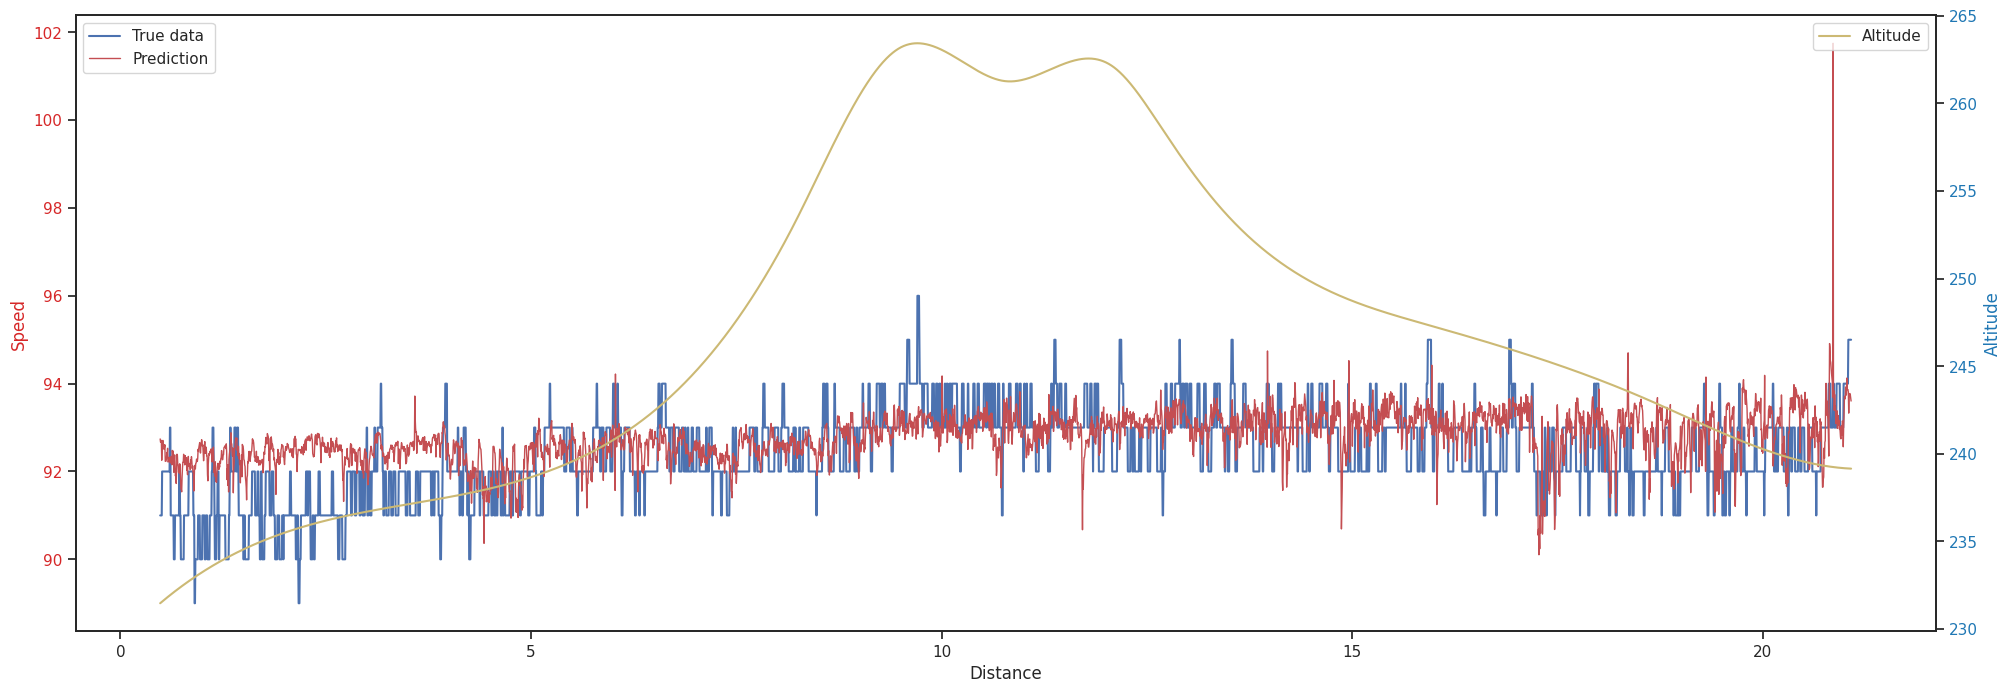

In [206]:
from sklearn.linear_model import Ridge, LinearRegression, RidgeCV,ElasticNetCV, LassoCV
clf = RidgeCV()
percent_delay = int(len(test_df) * 0.02) ## 2% delay
clf.fit(train_df, cad_train)
y_pred_cad =clf.predict(test_df)
_, _ = evl.plot(df=test_df[percent_delay:],pred=y_pred_cad[percent_delay:],endog='enhanced_speed',true_data=cad_test[percent_delay:])
print(evl.rmse(actual=cad_test,predicted=y_pred_cad))

In [207]:
train_df['cadence'] = cad_train
test_df['cadence'] = y_pred_cad

In [208]:
from feature_engine.timeseries.forecasting import WindowFeatures
lagged_cols = ['cadence']
lagged = 18
for lag in range(1,lagged):
    wft = WindowFeatures(variables=lagged_cols,
                         window=lag)
    train_df = wft.fit_transform(train_df)
    test_df = wft.fit_transform(test_df)

In [209]:
train_df = fit.clean_data(train_df)
test_df = fit.clean_data(test_df)

11.223770273218879


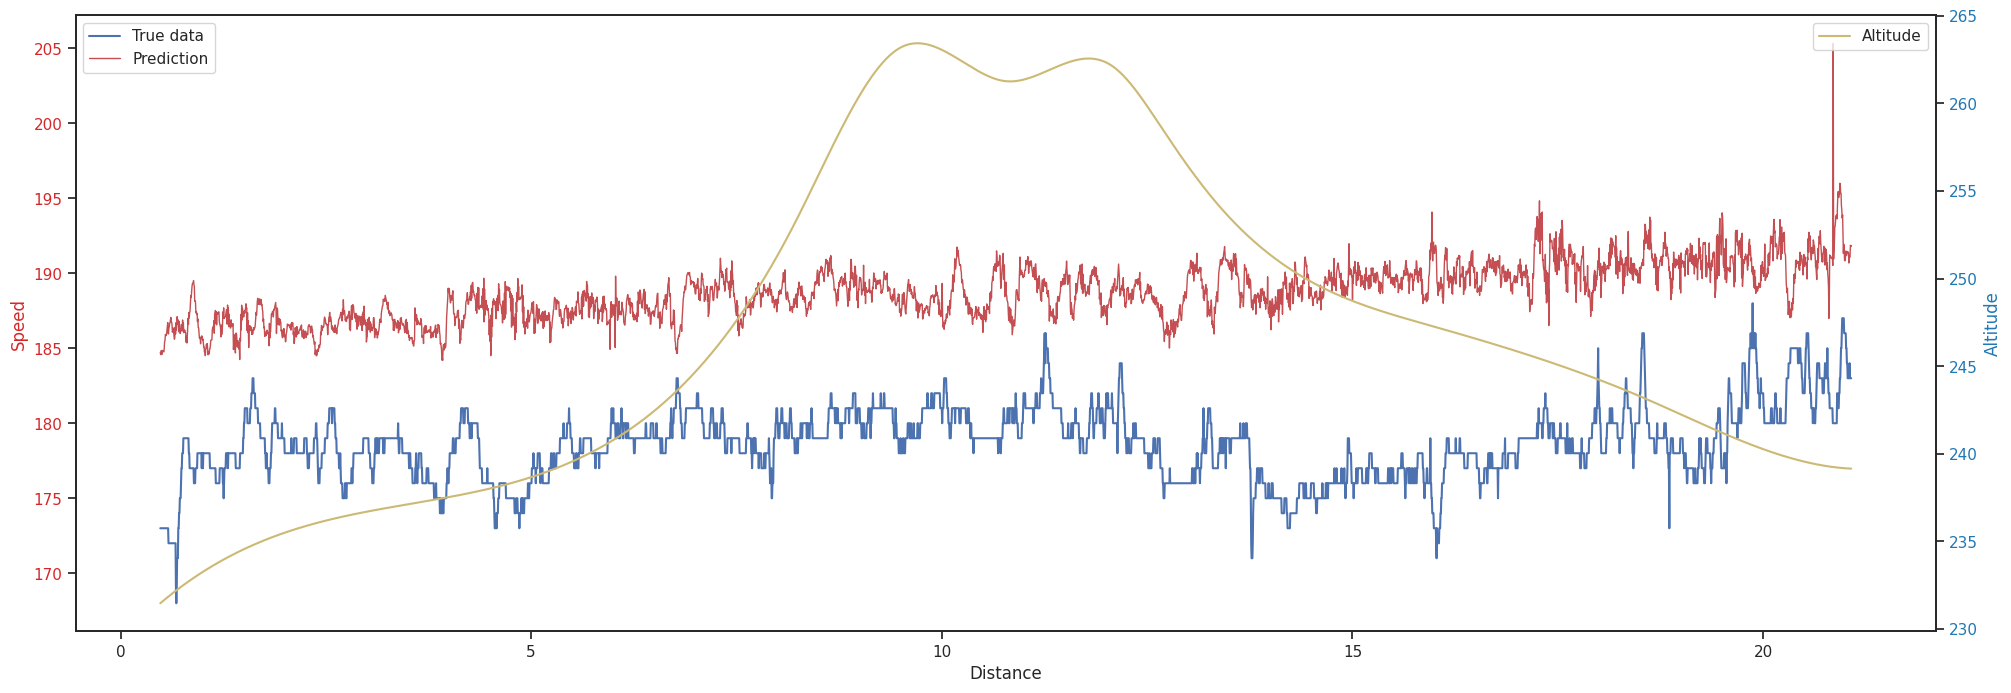

In [210]:
from sklearn.linear_model import Ridge, LinearRegression, ElasticNetCV
clf = RidgeCV()
percent_delay = int(len(test_df) * 0.02) ## 2% delay
clf.fit(train_df, heart_train)
y_pred_hr =clf.predict(test_df)
_, _ = evl.plot(df=test_df[percent_delay:],pred=y_pred_hr[percent_delay:],endog='enhanced_speed',true_data=heart_test[percent_delay:])
print(evl.rmse(actual=heart_test,predicted=y_pred_hr))

In [211]:
train_df['heart_rate'] = heart_train
test_df['heart_rate'] = y_pred_hr

In [212]:
from feature_engine.timeseries.forecasting import WindowFeatures
lagged_cols = ['heart_rate']
lagged = 18
for lag in range(1,lagged):
    wft = WindowFeatures(variables=lagged_cols,
                         window=lag)
    train_df = wft.fit_transform(train_df)
    test_df = wft.fit_transform(test_df)

In [213]:
from feature_engine.timeseries.forecasting import WindowFeatures
lagged_cols = ['heart_rate']
lagged = 4
for lag in range(1,lagged):
    wft = WindowFeatures(variables=lagged_cols,
                         window=lag,
                         periods=7)
    train_df = wft.fit_transform(train_df)
    test_df = wft.fit_transform(test_df)

In [214]:
from scipy.ndimage import uniform_filter1d
for x in range(10,110,10):
    train_df[f'moved_heart_rate_{x}'] = uniform_filter1d(train_df.heart_rate, size=x)
    test_df[f'moved_heart_rate_{x}'] = uniform_filter1d(test_df.heart_rate, size=x)

In [215]:
train_df = fit.clean_data(train_df)
test_df = fit.clean_data(test_df)

1.1972066591496053


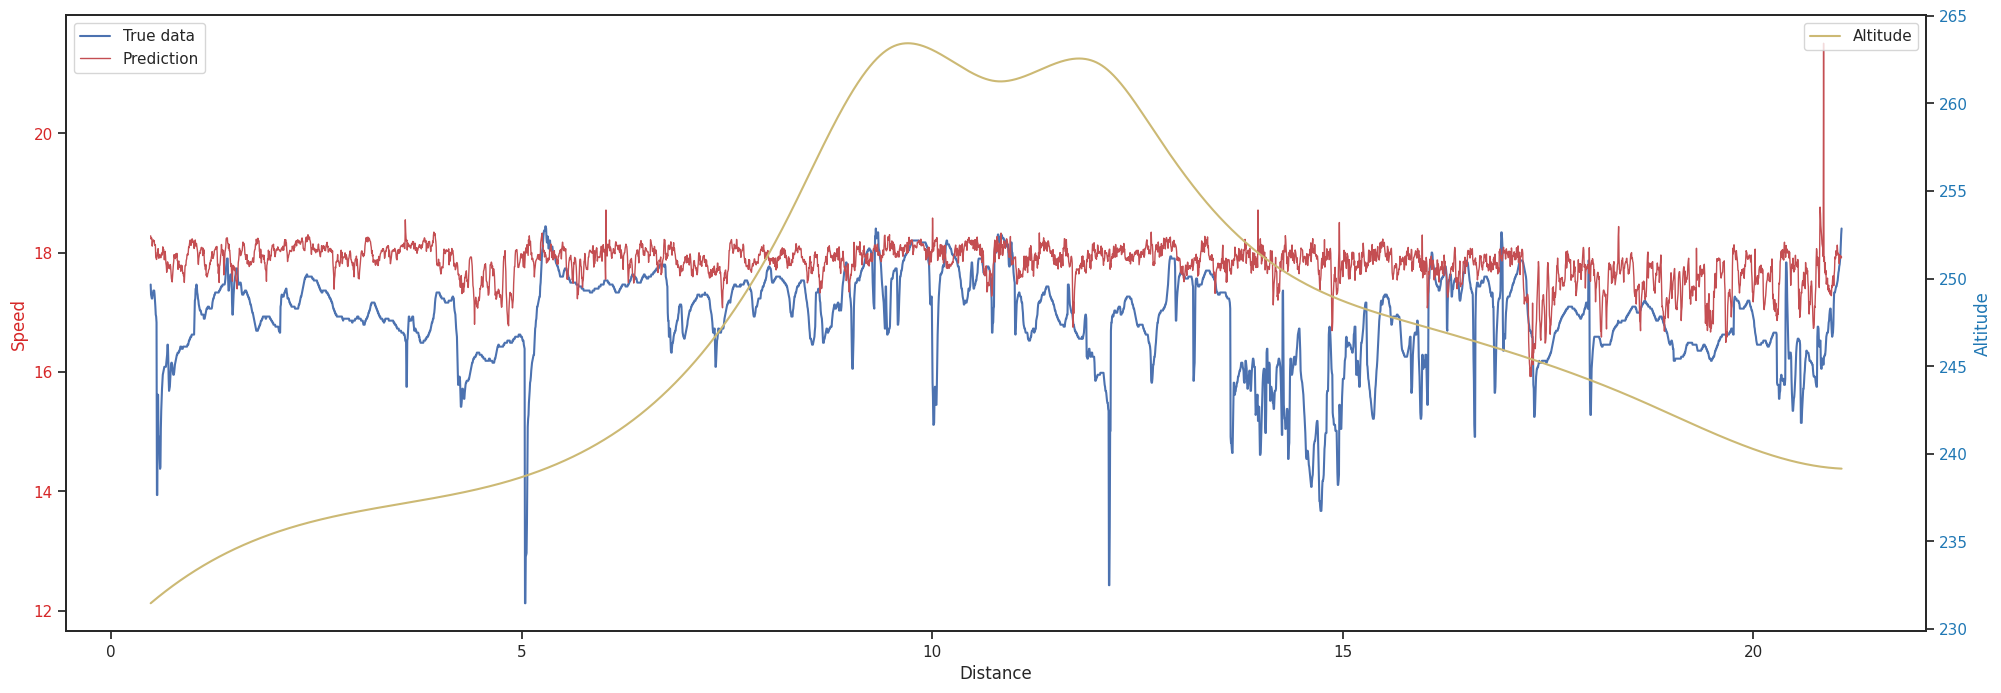

In [216]:
from sklearn.linear_model import Ridge, LinearRegression, RidgeCV
clf = RidgeCV()
percent_delay = int(len(test_df) * 0.02) ## 2% delay
clf.fit(train_df, speed_train)
y_pred_ridge =clf.predict(test_df)
_, _ = evl.plot(df=test_df[percent_delay:],pred=y_pred_ridge[percent_delay:],endog='enhanced_speed',true_data=speed_test[percent_delay:])
print(evl.rmse(actual=speed_test,predicted=y_pred_ridge))

In [217]:
import math
np.mean(speed_test),np.mean(y_pred_ridge),max(test_df.distance)
time = ((max(test_df.distance)/1000) / np.mean(y_pred_ridge))*60
minutes = math.floor(time)
seconds = round((time-minutes)*60)
f'Final time: {minutes}:{seconds}'

'Final time: 70:53'